


# 导入有关的包

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import optimizers
import time





Duplicate key in file PosixPath('/home/aronbryant/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 252 ('font.family:  sans-serif')
Duplicate key in file PosixPath('/home/aronbryant/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 260 ('font.sans-serif: DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif')
Duplicate key in file PosixPath('/home/aronbryant/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 403 ('axes.unicode_minus: True  # use Unicode for the minus symbol rather than hyphen.  See')


In [2]:
def creat_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i: (i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i+look_back])
    return np.array(dataX), np.array(dataY)

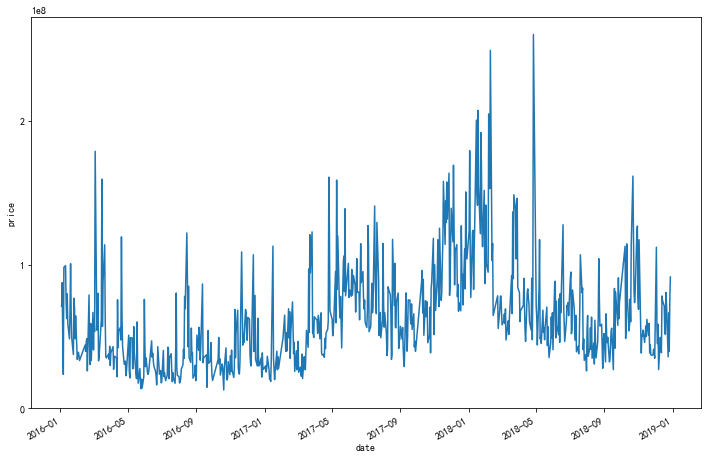

In [3]:
### 读取数据

dataframe = pd.read_csv('zgpa_train.csv',
                        header=0, parse_dates=[0],
                        index_col=0, usecols=[0, 5], squeeze=True)
dataset = dataframe.values
dataframe.head(10)


## 画出图形

plt.figure(figsize=(12, 8))
dataframe.plot()
plt.ylabel('price')
plt.yticks(np.arange(0, 300000000, 100000000))
plt.show()

In [4]:

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))


train_size = int(len(dataset)*0.8)
test_size = len(dataset)-train_size
train, test = dataset[0: train_size], dataset[train_size: len(dataset)]


look_back = 1
trainX, trainY = creat_dataset(train, look_back)
testX, testY = creat_dataset(test, look_back)


In [5]:
model = Sequential()

model.add(LSTM(input_dim=1, units=50, return_sequences=True))
#model.add(Dropout(0.2))

model.add(LSTM(input_dim=50, units=100, return_sequences=True))
#model.add(Dropout(0.2))

model.add(LSTM(input_dim=100, units=200, return_sequences=True))
#model.add(Dropout(0.2))

model.add(LSTM(300, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(100))
model.add(Dense(units=1))

model.add(Activation('relu'))
start = time.time()
model.compile(loss='mean_squared_error', optimizer='Adam')
model.summary()


history = model.fit(trainX, trainY, batch_size=64, epochs=50, 
                    validation_split=0.1, verbose=2)
print('compilatiom time:', time.time()-start)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 50)          10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 100)         60400     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 200)         240800    
_________________________________________________________________
lstm_3 (LSTM)                (None, 300)               601200    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               30100     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [6]:

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

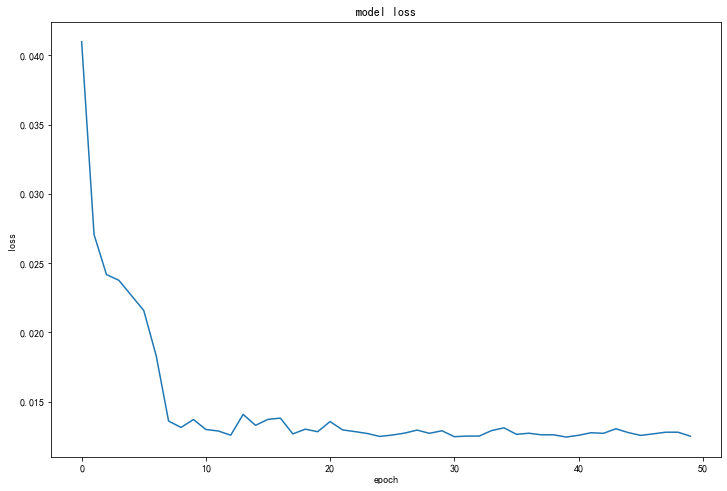

In [7]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:] = np.nan
trainPredictPlot = np.reshape(trainPredictPlot, (dataset.shape[0], 1))
trainPredictPlot[look_back: len(trainPredict)+look_back, :] = trainPredict


testPredictPlot = np.empty_like(dataset)
testPredictPlot[:] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1))
testPredictPlot[len(trainPredict)+(look_back*2)+1: len(dataset)-1, :] = testPredict


fig1 = plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()


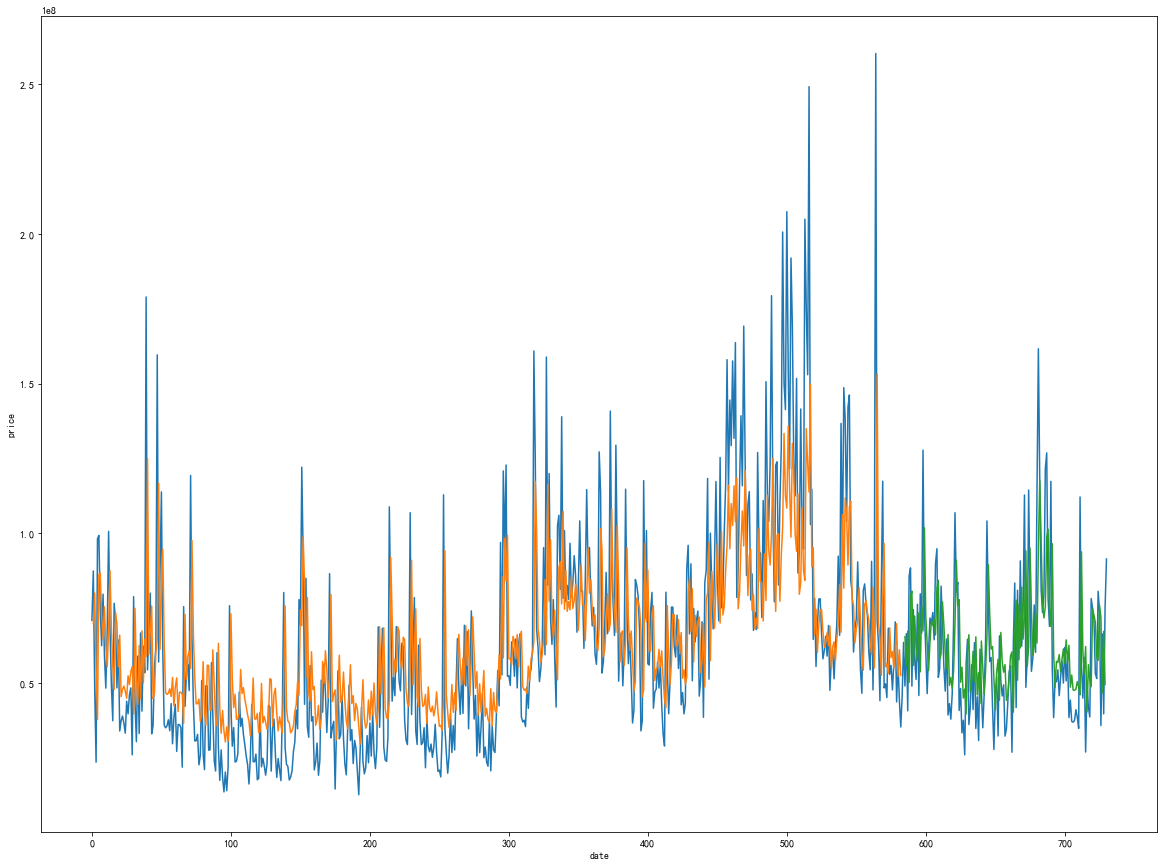

In [8]:
fig2 = plt.figure(figsize=(20, 15))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.ylabel('price')
plt.xlabel('date')
plt.show()


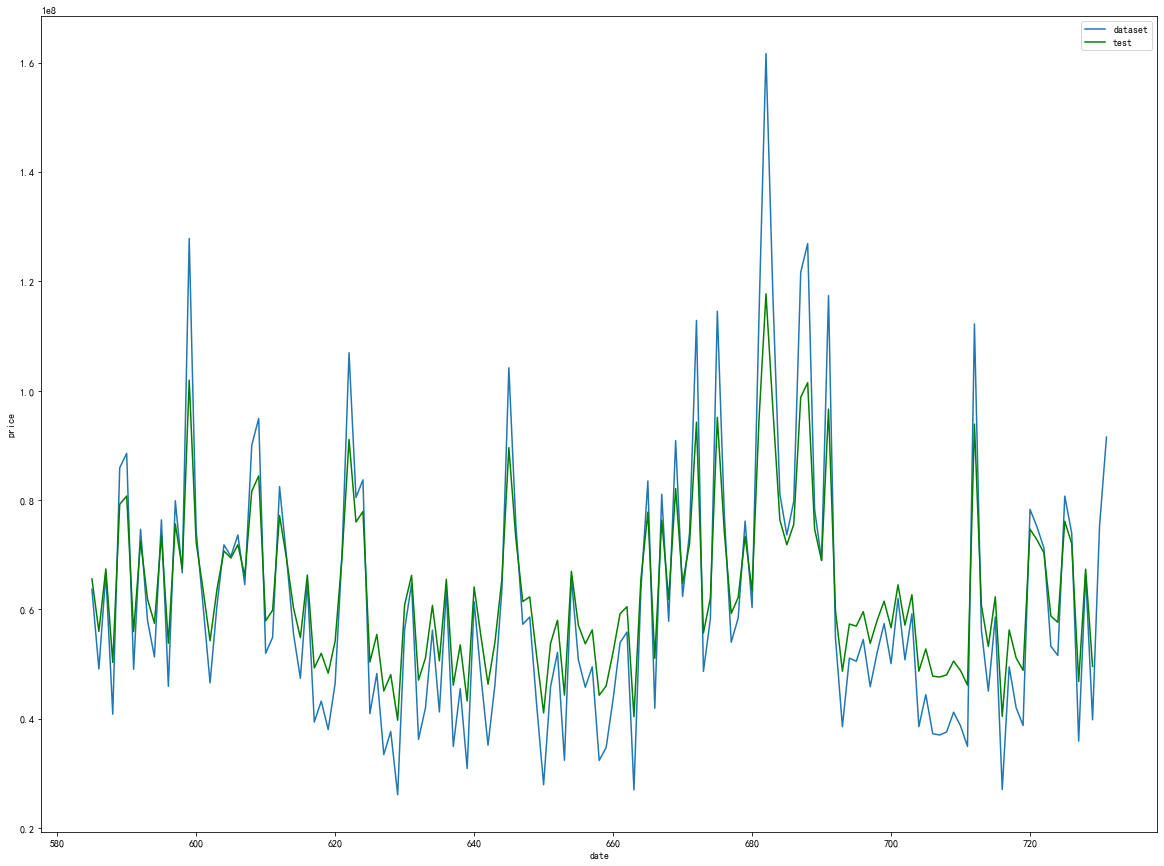

In [9]:
fig3 = plt.figure(figsize=(20, 15))
plt.plot(np.arange(train_size+1, len(dataset)+1, 1), scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot, 'g', label='test')
plt.ylabel('price')
plt.xlabel('date')
plt.legend()
plt.show()
